# Libaries / Modules

In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer

stopWords = set(stopwords.words('english'))
stopWords = stopWords.union(set(['com', 'org', 'java']))

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
import pickle
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Reshape
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model
from tensorflow.keras.initializers import Constant
from keras.layers import Layer
from tensorflow.keras.layers import Embedding
import keras
import tensorflow.keras.backend as K
import random
from keras.callbacks import EarlyStopping
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.utils.class_weight
from sklearn import metrics

import matplotlib.pyplot as plt

In [13]:
tqdm.pandas()

# Loading Data

In [14]:
SOURCE = "sakai"

# 'apache', 243k, 
# 'redhat', 106k
# 'jira', 98k

# 'mongodb', 38k
# 'qt', 36k

# 'sakai', 19k
# 'hyperledger', 16k 
# 'mariadb', 15k
# 'spring', 14k
# 'jiraecosystem', 11k

# 'sonatype', 4k, small
# 'jfrog', 3k, small
# 'inteldaos', 3k too small

# 'secondlife', 630 too small
# 'mindville', 44 too small

In [16]:
#Loading Issues & Links
filename = '../data/crawl/issues_'+SOURCE.lower()+'.csv'
issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=['issue_id'], sep=";")
print("Number of Issues: " + str(len(issues)))
print("Feature Size: " + str(len(list(issues.columns.values))))

filename = '../data/crawl/clean_links_'+SOURCE.lower()+'.csv'
links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0)
print("Number of Links: " + str(len(links)))
print("Feature Size: "+str(len(list(links.columns.values))))

Number of Issues: 49204
Feature Size: 9
Number of Links: 19057
Feature Size: 5


In [17]:
links.linktype.value_counts()

Relate             9272
Subtask            3348
Depend             2449
Duplicate          1807
Incorporate        1270
Cloners             910
Git Code Review       1
Name: linktype, dtype: int64

In [18]:
type_dict={'Backports': 'Workflow', 
           
    'Blocked': 'Temporal/Causal',
    'Blocker': 'Temporal/Causal',
    'Blocks': 'Temporal/Causal',
           
    'Bonfire Testing': 'Workflow', 
    'Bonfire testing': 'Workflow', 
    'Git Code Review': 'Workflow', 
    'Testing': 'Workflow',
           
    'Causality': 'Temporal/Causal', 
    'Cause': 'Temporal/Causal',
    'Caused': 'Temporal/Causal', 
    'Problem/Incident': 'Temporal/Causal',
           
    'Child-Issue': 'Composition', 
    'Parent Feature': 'Composition',
    'Parent/Child': 'Composition',
    'multi-level hierarchy [GANTT]': 'Composition',
    'Parent-Relation': 'Composition',
           
    'Cloners': 'Duplication', 
    'Cloners (old)': 'Duplication', 
           
    'Collection': 'Composition', 
    'Container': 'Composition', 
    'Contains(WBSGantt)': 'Composition', 
    'Incorporate': 'Composition', 
    'Incorporates': 'Composition', 
    'Part': 'Composition',
    'PartOf': 'Composition',
    'Superset': 'Composition', 
           
    'Completes': 'Workflow', 
    'Fixes': 'Workflow',
    'Resolve': 'Workflow',
           
    'Depend': 'Temporal/Causal', 
    'Dependency': 'Temporal/Causal', 
    'Dependent': 'Temporal/Causal', 
    'Depends': 'Temporal/Causal', 
    'Gantt Dependency': 'Temporal/Causal',
    'dependent': 'Temporal/Causal',
           
    'Derived': 'Workflow',
           
    'Detail': 'Workflow', 
           
    'Documentation': 'Workflow',
    'Documented': 'Workflow',
    
    'Duplicate': 'Duplication',
           
    'Epic': 'Composition', 
    'Epic-Relation': 'Composition',
    
    'Finish-to-Finish link (WBSGantt)': 'Temporal/Causal', 
    'Gantt End to End': 'Temporal/Causal', 
    'Gantt: finish-finish': 'Temporal/Causal',
    'finish-finish [GANTT]': 'Temporal/Causal', 
    
    'Gantt End to Start': 'Temporal/Causal', 
    'Gantt: finish-start': 'Temporal/Causal',
    'finish-start [GANTT]': 'Temporal/Causal',

    'Gantt Start to Start': 'Temporal/Causal', 
    
    'Gantt: start-finish': 'Temporal/Causal', 
    
    'Follows': 'Temporal/Causal', 
    'Sequence': 'Temporal/Causal', 
    
    'Implement': 'Workflow', 
    'Implements': 'Workflow', 
    
    'Issue split': 'Composition',
    'Split': 'Composition',
    'Work Breakdown': 'Composition',
    
    'Preceded By': 'Temporal/Causal', 
    
    'Reference': 'General Relation',
    'Relate': 'General Relation',
    'Related': 'General Relation', 
    'Relates': 'General Relation',
    'Relationship': 'General Relation',
    
    'Regression': 'Workflow', 
    
    'Replacement': 'Duplication',
    
    'Required': 'Temporal/Causal', 
    
    'Supercedes': 'Workflow',
    'Supersede': 'Workflow',
    'Supersession': 'Workflow', 
    
    'Test': 'Workflow', 
    'Tested': 'Workflow',
    
    'Trigger': 'Workflow',
           
    'Subtask': 'Composition',
           
    'Non-Link': 'Non-Link'}

In [19]:
links['mappedtype'] = links['linktype'].map(type_dict)
links.mappedtype.value_counts()

General Relation    9272
Composition         4618
Duplication         2717
Temporal/Causal     2449
Workflow               1
Name: mappedtype, dtype: int64

In [20]:
lt = "Duplication"

## Create Embeddings

In [21]:
p = PorterStemmer()

textual_data = []
for issue_id in tqdm(issues.index):
    temp = []
    for word in word_tokenize(str(issues['title'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)
    temp = []
    for word in word_tokenize(str(issues['description'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)

100%|██████████| 49204/49204 [01:31<00:00, 535.68it/s] 


In [22]:
EMBEDDING_DIM = 20

In [23]:
model_CBOW = gensim.models.Word2Vec(textual_data, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)

# Data Split

In [24]:
def get_linked_issues(df):
    df['issues']=''
    for i in range(len(df)):
        df["issues"].iloc[i] = str(sorted(set([df.iloc[i]['issue_id_1'], df.iloc[i]['issue_id_2']])))

## Get Link type

In [25]:
other_link_df = links[links["mappedtype"]!=lt]
print(len(other_link_df))

linktype_df = links[links["mappedtype"]==lt]
print(len(linktype_df))

16340
2717


In [26]:
random_trainval_lt, random_test_lt = train_test_split(linktype_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_lt))
print(len(random_test_lt))

get_linked_issues(random_trainval_lt)
get_linked_issues(random_test_lt)

2173
544


<ipython-input-24-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## Get Other-Links

In [27]:
random_trainval_otherlink, random_test_otherlink = train_test_split(other_link_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_otherlink))
print(len(random_test_otherlink))

get_linked_issues(random_trainval_otherlink)
get_linked_issues(random_test_otherlink)

random_trainval_ol_index = random.sample(set(random_trainval_otherlink.index), len(random_trainval_lt))
random_test_ol_index = random.sample(set(random_test_otherlink.index), len(random_test_lt))

random_trainval_ol = random_trainval_otherlink.loc[random_trainval_ol_index]
random_test_ol = random_test_otherlink.loc[random_test_ol_index]

13072
3268


<ipython-input-24-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''


## Create Non-Links

In [28]:
issues['resolution'].value_counts()

Fixed               30819
Open                 5622
Won't Fix            4898
Duplicate            2465
Non-Issue            2208
Incorporated         1353
Cannot Reproduce     1156
Incomplete            470
No Resources          159
Done                   38
Won't Do               16
Name: resolution, dtype: int64

In [29]:
import random
non_link_issues = set(issues[~issues['resolution'].isin(['Duplicate', 'Open'])].index)

no_issues = len(non_link_issues)

cols = ['name', 'linktype', 'mappedtype', 'issue_id_1', 'issue_id_2', 'issues']
non_links_df = pd.DataFrame(columns = cols)

for i in tqdm(range(links.mappedtype.value_counts()[lt])):
    sample = random.sample(non_link_issues, 2)
    name = str(sample[0]) + "_" + str(sample[1])
    non_links_df = non_links_df.append({
        "name": name,
        "linktype": "Non-Link",
        "mappedtype": "Non-Link",
        "issue_id_1":  sample[0],
        "issue_id_2":  sample[1],
        "issues": str(sorted(set([sample[0], sample[1]])))
    }, ignore_index=True)
    
random_trainval_nl, random_test_nl = train_test_split(non_links_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_nl))
print(len(random_test_nl))

100%|██████████| 2717/2717 [00:06<00:00, 395.33it/s]

2173
544


In [30]:
len(random_trainval_lt)

2173

In [31]:
len(random_trainval_ol)

2173

## Merging Datasets

### Dataset 1 Link type vs Non-Links

In [32]:
random_train_1 = random_trainval_lt.append(random_trainval_nl, ignore_index=True)

print(len(random_train_1))

4346


### Dataset 2 Link type vs Other Links

In [33]:
random_train_2 = random_trainval_lt.append(random_trainval_ol, ignore_index=True)

print(len(random_train_2))

4346


### Dataset 3 Link type vs Non-Links + Other-Links

In [34]:
random_trainval_olnl_all = random_trainval_ol.append(random_trainval_nl, ignore_index=True)

random_trainval_olnl_index = random.sample(set(random_trainval_olnl_all.index), len(random_trainval_lt))

random_trainval_olnl = random_trainval_olnl_all.loc[random_trainval_olnl_index]

random_train_3 = random_trainval_lt.append(random_trainval_olnl, ignore_index=True)

print(len(random_train_3))

4346


### Dataset 4 Link type + Other-Links vs Non-Links

In [35]:
random_trainval_ollt_all = random_trainval_ol.append(random_trainval_lt, ignore_index=True)

random_trainval_ollt_index = random.sample(set(random_trainval_ollt_all.index), len(random_trainval_nl))

random_trainval_old = random_trainval_ollt_all.loc[random_trainval_ollt_index]

random_train_4 = random_trainval_nl.append(random_trainval_old, ignore_index=True)

print(len(random_train_4))

4346


### Test Set

In [36]:
random_test_temp = random_test_lt.append(random_test_nl, ignore_index=True)
random_test_lt = random_test_temp.append(random_test_ol, ignore_index=True)
random_test_linked = random_test_temp.append(random_test_ol, ignore_index=True)

print(len(random_test_lt))
print(len(random_test_linked))

1632
1632


## Clean up

In [37]:
def clean_link_set(link_df):
    # Sanity-Check for Duplicates
    print("With duplicate entries: "+str(len(link_df)))
    link_df.drop_duplicates(inplace=True)
    print("Without duplicate entries: "+str(len(link_df)))
    
    doublelinks = (link_df.issues.value_counts()>1).rename_axis('doubles').reset_index(name='valid')
    valid_doubles = set(doublelinks[doublelinks['valid']==True]['doubles'])
    
    print("With issue pairs with multiple link types: "+str(len(link_df)))
    for i in tqdm(valid_doubles):
        if len(set(link_df[link_df['issues']==i]['linktype']))>1:
            link_df=link_df[link_df.issues != i]
    print("Without issue pairs with multiple link types: "+str(len(link_df)))
    
    #Multiple links complete remove
    print("With issue pairs with multiple entries: "+str(len(link_df)))
    link_df.drop_duplicates(subset=['issues'], inplace=True)
    print("Without issue pairs with multiple entries: "+str(len(link_df)))
    
    return link_df

In [38]:
def lt_set(label):
    if label == lt:
        return 1
    elif label == 'Non-Link':
        return 0
    else:
        return 0
    
def link_set(label):
    if label == 'Non-Link':
        return 0
    else:
        return 1

In [39]:
random_sets = {'R_LTvNL_train': random_train_1, 
               'R_LTvOL_train': random_train_2, 
               'R_LTvNLOL_train': random_train_3, 
               'R_LTOLvNL_train': random_train_4,
               'R_test_lt': random_test_lt,
               'R_test_linked': random_test_linked}

In [40]:
for dataset in random_sets.keys():
    print(dataset)
    print(len(temp))
    temp = random_sets[dataset]
    temp = clean_link_set(temp)
    
    random_sets[dataset] = temp

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

R_LTvNL_train
68
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTvOL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTvNLOL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTOLvNL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
Wit

In [41]:
issues['text']=issues['description']+" "+issues["title"]

issues['text'] = issues['text'].apply(lambda x: str(x).replace("\n", " "))
issues['text'] = issues['text'].apply(lambda x: str(x).replace("\t", " "))

issue_text_data = issues['text']

In [42]:
for dataset in random_sets.keys():
    print(dataset)
    
    temp = random_sets[dataset]
    temp = temp.merge(issue_text_data, left_on='issue_id_1', right_on='issue_id')
    temp = temp.merge(issue_text_data, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))
    random_sets[dataset] = temp

R_LTvNL_train
R_LTvOL_train
R_LTvNLOL_train
R_LTOLvNL_train
R_test_lt
R_test_linked


## Linktype Mapping for Data sets

In [43]:
for dataset in random_sets.keys():
    print(dataset)
    temp = random_sets[dataset]
    
    temp['mappedtype'] = temp['linktype'].map(type_dict)
    temp.mappedtype.value_counts()
    
    temp['label'] = 0
    if dataset in ['R_LTOLvNL_train', 'R_test_linked']:
        temp['label'] = temp['mappedtype'].map(link_set)
    else:
        temp['label'] = temp['mappedtype'].map(lt_set)
        
    random_sets[dataset] = temp
    
    print(temp.groupby(['mappedtype', 'label']).size())

R_LTvNL_train
mappedtype   label
Duplication  1        2173
Non-Link     0        2173
dtype: int64
R_LTvOL_train
mappedtype        label
Composition       0         647
Duplication       1        2173
General Relation  0        1221
Temporal/Causal   0         304
Workflow          0           1
dtype: int64
R_LTvNLOL_train
mappedtype        label
Composition       0         330
Duplication       1        2173
General Relation  0         601
Non-Link          0        1095
Temporal/Causal   0         146
Workflow          0           1
dtype: int64
R_LTOLvNL_train
mappedtype        label
Composition       1         323
Duplication       1        1070
General Relation  1         612
Non-Link          0        2173
Temporal/Causal   1         168
dtype: int64
R_test_lt
mappedtype        label
Composition       0        151
Duplication       1        544
General Relation  0        307
Non-Link          0        544
Temporal/Causal   0         86
dtype: int64
R_test_linked
mappedtype     

# Model

In [44]:
print("Creating functions.")
def plot_history(history):
#     keys = history.history.keys()
    for i in list(history.history)[0:2]:
        print(i)
        # list all data in history
        # summarize history for accuracy
        plt.plot(history.history[i])        
        plt.plot(history.history['val_'+i])
        plt.title('model '+ i)
        plt.ylabel(i)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Creating functions.


In [45]:
def get_matrices(df_set):
    c=0
    matrix = []
    tags = []
    for i in range(len(df_set)): #contains preprocessed bug reports
        m1 = np.zeros((300,20))
        m2 = np.zeros((300,20))
        count = 0
        line1 = df_set['text_1'].iloc[i]
        line2 = df_set['text_2'].iloc[i]
        words1 = str(line1).split(' ')
        words2 = str(line2).split(' ')
        for word in words1:
    #         print(word)
            if count<300:
                if word in model_CBOW.wv:
                    m1[count,:]=model_CBOW.wv[word]
                    count+=1
                else:
                    count+=1
        count = 0    
        for word in words2:
    #         print(word)
            if count<300:
                if word in model_CBOW.wv:
                    m2[count,:]=model_CBOW.wv[word]
                    count+=1
                else:
                    count+=1
        tag = df_set['label'].iloc[i]
        tags.append(tag)
        m1 = m1.reshape(300,20,1)
        m2 = m2.reshape(300,20,1)
        c+=1
        matrix_temp=np.append(m1,m2,axis=2)
        matrix.append(matrix_temp)

    print(c)
    
    return matrix, tags

In [46]:
def get_session(gpu_fraction=0.3):
    """
    This function is to allocate GPU memory a specific fraction
    Assume that you have 6GB of GPU memory and want to allocate ~2GB
    """
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## DC-CNN Model

In [47]:
def DCCNN_Model(input_shape):
    X_input = Input(shape=input_shape)
    
    X_1 = Conv2D(100, kernel_size=(1,20), strides=(1,1), activation='relu')(X_input)
    X_1 = layers.normalization.BatchNormalization(axis=-1)(X_1)
    X_1 = Reshape((300,100,1))(X_1)
    
    
    X_1_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_1)
    X_1_1 = layers.normalization.BatchNormalization(axis=-1)(X_1_1)
    X_1_1 = MaxPooling2D(pool_size=(300,1),padding='valid')(X_1_1)
    X_1_1 = Flatten()(X_1_1)
    X_1_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_1)
    X_1_2 = layers.normalization.BatchNormalization(axis=-1)(X_1_2)
    X_1_2 = MaxPooling2D(pool_size=(299,1),padding='valid')(X_1_2)
    X_1_2 = Flatten()(X_1_2)
    X_1_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_1)
    X_1_3 = layers.normalization.BatchNormalization(axis=-1)(X_1_3)
    X_1_3 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_1_3)
    X_1_3 = Flatten()(X_1_3)
    
    X_1 = layers.Concatenate(axis=-1)([X_1_1,X_1_2])
    X_1 = layers.Concatenate(axis=-1)([X_1,X_1_3])
    
    X_2 = Conv2D(100, kernel_size=(2,20), strides=(1,1),activation='relu')(X_input)
    X_2 = layers.normalization.BatchNormalization(axis=-1)(X_2)
    X_2 = Reshape((299,100,1))(X_2)
    
    X_2_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_2)
    X_2_1 = layers.normalization.BatchNormalization(axis=-1)(X_2_1)
    X_2_1 = MaxPooling2D(pool_size=(299,1),padding='valid')(X_2_1)
    X_2_1 = Flatten()(X_2_1)
    X_2_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_2)
    X_2_2 = layers.normalization.BatchNormalization(axis=-1)(X_2_2)
    X_2_2 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_2_2)
    X_2_2 = Flatten()(X_2_2)
    X_2_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_2)
    X_2_3 = layers.normalization.BatchNormalization(axis=-1)(X_2_3)
    X_2_3 = MaxPooling2D(pool_size=(297,1),padding='valid')(X_2_3)
    X_2_3 = Flatten()(X_2_3)
    
    X_2 = layers.Concatenate(axis=-1)([X_2_1,X_2_2])
    X_2 = layers.Concatenate(axis=-1)([X_2,X_2_3])
    
    X_3 = Conv2D(100, kernel_size=(3,20), strides=(1,1),activation='relu')(X_input)
    X_3 = layers.normalization.BatchNormalization(axis=-1)(X_3)
    X_3 = Reshape((298,100,1))(X_3)
    
    X_3_1 = Conv2D(200, kernel_size=(1,100), strides=(1,1),activation='relu')(X_3)
    X_3_1 = layers.normalization.BatchNormalization(axis=-1)(X_3_1)
    X_3_1 = MaxPooling2D(pool_size=(298,1),padding='valid')(X_3_1)
    X_3_1 = Flatten()(X_3_1)
    X_3_2 = Conv2D(200, kernel_size=(2,100), strides=(1,1),activation='relu')(X_3)
    X_3_2 = layers.normalization.BatchNormalization(axis=-1)(X_3_2)
    X_3_2 = MaxPooling2D(pool_size=(297,1),padding='valid')(X_3_2)
    X_3_2 = Flatten()(X_3_2)
    X_3_3 = Conv2D(200, kernel_size=(3,100), strides=(1,1),activation='relu')(X_3)
    X_3_3 = layers.normalization.BatchNormalization(axis=-1)(X_3_3)
    X_3_3 = MaxPooling2D(pool_size=(296,1),padding='valid')(X_3_3)
    X_3_3 = Flatten()(X_3_3)
    
    X_3 = layers.Concatenate(axis=-1)([X_3_1,X_3_2])
    X_3 = layers.Concatenate(axis=-1)([X_3,X_3_3])
    
    X = layers.Concatenate(axis=-1)([X_1,X_2])
    X = layers.Concatenate(axis=-1)([X,X_3])
    
    X = Dropout(0.6)(X)
    X = Dense(300, activation='relu')(X)
    X = layers.normalization.BatchNormalization(axis=-1)(X)
    
    
    X = Dropout(0.4)(X)
    X = Dense(100, activation='relu')(X)
    X = layers.normalization.BatchNormalization(axis=-1)(X)

    
    X = Dropout(0.4)(X)
    Y = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = Y, name='CNN_Model')
    
#     print(model.summary())
    
    return model

In [48]:
def train_model(df_train):
    # tf.set_random_seed(1)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

    matrix_train, tags_train = get_matrices(df_train)
    
    data_train = []
    label_train = []

    data_train = np.array(matrix_train)
    label_train = np.array(tags_train)

    index = [i for i in range(len(data_train))] 
    random.shuffle(index)
    data_train = data_train[index]
    label_train = label_train[index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=2)

    dccnnModel = DCCNN_Model((300, 20, 2))
    dccnnModel.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])
    hist = dccnnModel.fit(x=data_train, y=label_train, batch_size=64, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    plot_history(hist)
    
    K.clear_session()
    
    return dccnnModel

In [49]:
def eval_model(model, df_test, link):
    matrix_test, tags_test = get_matrices(df_test)
    
    data_test = []
    label_test = []

    data_test = np.array(matrix_test)
    label_test = np.array(tags_test)
    
    ## Get predictions
    preds = model.predict(np.array(data_test))
    roundelt_preds = np.round(preds).astype(int)

    class_rep = classification_report(label_test, roundelt_preds, output_dict=True)
    class_rep_df = pd.DataFrame(class_rep).transpose()
    
    auc = metrics.roc_auc_score(label_test, preds)
    acc = class_rep_df['precision'].loc['accuracy']

    print(class_rep_df)

    conf_mat = confusion_matrix(label_test, roundelt_preds)

    print(pd.DataFrame(conf_mat, index=[0, 1], columns=[0, 1]))
    
    df_test_preds = df_test
    df_test_preds['pred'] = roundelt_preds
    
    conf_mat_comp = df_test_preds.groupby(['mappedtype', 'pred']).size()
    
    lt_preds = df_test_preds[(df_test_preds['mappedtype']==lt)][['mappedtype', 'pred']]
    ol_preds = df_test_preds[(df_test_preds['mappedtype']!='Non-Link')&(df_test_preds['mappedtype']!=lt)][['mappedtype', 'pred']]    
    nl_preds = df_test_preds[(df_test_preds['mappedtype']=='Non-Link')][['mappedtype', 'pred']]
    
    lt_cf = lt_preds['pred'].value_counts()
    ol_cf = ol_preds['pred'].value_counts()
    nl_cf = nl_preds['pred'].value_counts()
    
    try:
        LT0 = lt_cf[0]
    except:
        LT0 = 0
        
    try:    
        LT1 = lt_cf[1]
    except:
        LT1 = 0
        
    try:
        OL0 = ol_cf[0]
    except:
        OL0 = 0
        
    try:
        OL1 = ol_cf[1]
    except:
        OL1 = 0
        
    try:
        NL0 = nl_cf[0]
    except:
        NL0 = 0
        
    try:
        NL1 = nl_cf[1]
    except:
        NL1 = 0
    
    conf_mat_df = pd.DataFrame(columns = ['Class', '0', '1'])
    
    conf_mat_df.loc[len(conf_mat_df)] = [lt.upper(), LT0, LT1]
    conf_mat_df.loc[len(conf_mat_df)] = ["OTHER-LINKS", OL0, OL1]
    conf_mat_df.loc[len(conf_mat_df)] = ["NON-LINKS", NL0, NL1]
    
    print(conf_mat_df)
    
    if link:
        try:
            lt_pre = LT1 / (LT1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
    
        try:
            ol_pre = OL1 / (OL1+NL1)
        except:
            ol_pre = 0
        ol_rec = OL1 / (OL1+OL0)
        
        try:
            nl_pre = NL0 / (NL0+LT0+OL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['1'].to_list()
        
    else:
        try:
            lt_pre = LT1 / (LT1+OL1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
        
        try:
            ol_pre = OL0 / (LT0+OL0)
        except:
            ol_pre = 0
        ol_rec = OL0 / (OL0+OL1)
        
        try:
            nl_pre = NL0 / (LT0+NL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['0'].to_list()

    lt_f1 = 2*(lt_pre*lt_rec)/(lt_pre+lt_rec)
    
    ol_f1 = 2*(ol_pre*ol_rec)/(ol_pre+ol_rec)
        
    nl_f1 = 2*(nl_pre*nl_rec)/(nl_pre+nl_rec)
    
    lt_metrics = [lt, lt_pre, lt_rec, lt_f1]
    ol_metrics = ['Other-Links', ol_pre, ol_rec, ol_f1]
    nl_metrics = ['Non-Links', nl_pre, nl_rec, nl_f1]
    
    both_metrics.insert(0, 'Both')
    both_metrics = both_metrics[:-1]

    print(conf_mat_comp)
    
    return acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds

In [50]:
def do_model(dataset):
    sccnn_model = train_model(random_sets[dataset+'_train'])
    if dataset == 'R_LTOLvNL':
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_linked', True)
        
    else: 
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_lt', False)
    
    metrics_df.to_csv('results/dccnn_'+SOURCE+'_'+lt+'_'+dataset+'_metrics.csv', encoding='utf-8', index=False)
    accauc_df.to_csv('results/dccnn_'+SOURCE+'_'+lt+'_'+dataset+'_accauc.csv', encoding='utf-8', index=False)
    conf_mat_df.to_csv('results/dccnn_'+SOURCE+'_'+lt+'_'+dataset+'_confmat.csv', encoding='utf-8', index=False)
   
    print(conf_mat_df)
    print(accauc_df)
    print(metrics_df)
    
    return df_test_preds

def do_test(model, dataset, link):
    acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds = eval_model(model, random_sets[dataset], link)

    accauc_df = pd.DataFrame(columns = ['Dataset', 'ACC', 'AUC'])
    accauc_df = accauc_df.append({
        "Dataset": dataset,
        "ACC": acc,
        "AUC": auc
    }, ignore_index=True)

    metrics_df = pd.DataFrame(columns = ['Class', 'Precision', 'Recall', 'F1'])
    metrics_df.loc[len(metrics_df)] = lt_metrics
    metrics_df.loc[len(metrics_df)] = nl_metrics
    metrics_df.loc[len(metrics_df)] = ol_metrics
    metrics_df.loc[len(metrics_df)] = both_metrics
    
    return metrics_df, accauc_df, conf_mat_df, df_test_preds

## Random

4346
Epoch 00046: early stopping
loss


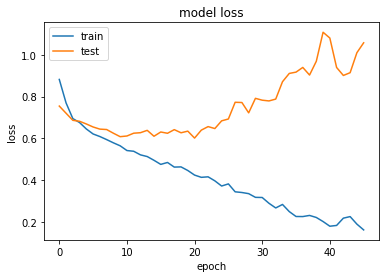

accuracy


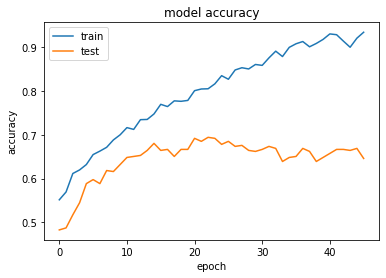

1632
              precision    recall  f1-score      support
0              0.783875  0.643382  0.706714  1088.000000
1              0.474966  0.645221  0.547155   544.000000
accuracy       0.643995  0.643995  0.643995     0.643995
macro avg      0.629420  0.644301  0.626934  1632.000000
weighted avg   0.680905  0.643995  0.653528  1632.000000
     0    1
0  700  388
1  193  351
         Class    0    1
0  DUPLICATION  193  351
1  OTHER-LINKS  319  225
2    NON-LINKS  381  163
mappedtype        pred
Composition       0        91
                  1        60
Duplication       0       193
                  1       351
General Relation  0       173
                  1       134
Non-Link          0       381
                  1       163
Temporal/Causal   0        55
                  1        31
dtype: int64
         Class    0    1
0  DUPLICATION  193  351
1  OTHER-LINKS  319  225
2    NON-LINKS  381  163
     Dataset       ACC       AUC
0  R_test_lt  0.643995  0.716333
         Class 

In [51]:
LTvNL_preds = do_model('R_LTvNL')

4346
Epoch 00038: early stopping
loss


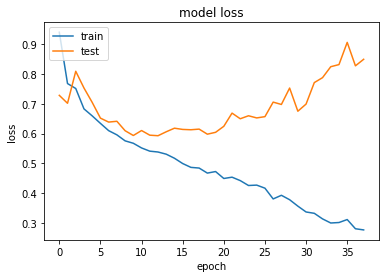

accuracy


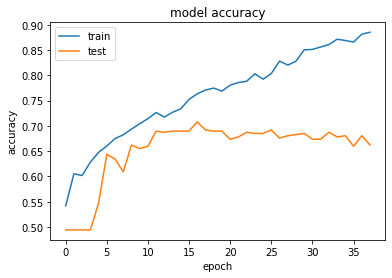

1632
              precision    recall  f1-score      support
0              0.790960  0.643382  0.709579  1088.000000
1              0.480589  0.659926  0.556158   544.000000
accuracy       0.648897  0.648897  0.648897     0.648897
macro avg      0.635775  0.651654  0.632869  1632.000000
weighted avg   0.687503  0.648897  0.658439  1632.000000
     0    1
0  700  388
1  185  359
         Class    0    1
0  DUPLICATION  185  359
1  OTHER-LINKS  375  169
2    NON-LINKS  325  219
mappedtype        pred
Composition       0       119
                  1        32
Duplication       0       185
                  1       359
General Relation  0       194
                  1       113
Non-Link          0       325
                  1       219
Temporal/Causal   0        62
                  1        24
dtype: int64
         Class    0    1
0  DUPLICATION  185  359
1  OTHER-LINKS  375  169
2    NON-LINKS  325  219
     Dataset       ACC       AUC
0  R_test_lt  0.648897  0.701911
         Class 

In [52]:
LTvOL_preds = do_model('R_LTvOL')

4346
Epoch 00041: early stopping
loss


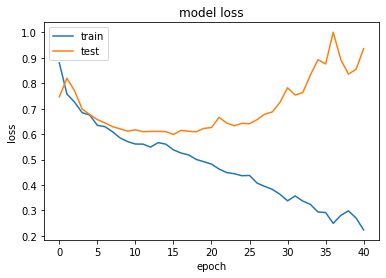

accuracy


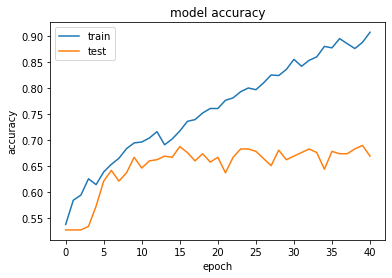

1632
              precision    recall  f1-score      support
0              0.773166  0.736213  0.754237  1088.000000
1              0.518456  0.568015  0.542105   544.000000
accuracy       0.680147  0.680147  0.680147     0.680147
macro avg      0.645811  0.652114  0.648171  1632.000000
weighted avg   0.688263  0.680147  0.683527  1632.000000
     0    1
0  801  287
1  235  309
         Class    0    1
0  DUPLICATION  235  309
1  OTHER-LINKS  411  133
2    NON-LINKS  390  154
mappedtype        pred
Composition       0       121
                  1        30
Duplication       0       235
                  1       309
General Relation  0       219
                  1        88
Non-Link          0       390
                  1       154
Temporal/Causal   0        71
                  1        15
dtype: int64
         Class    0    1
0  DUPLICATION  235  309
1  OTHER-LINKS  411  133
2    NON-LINKS  390  154
     Dataset       ACC       AUC
0  R_test_lt  0.680147  0.711577
         Class 

In [53]:
LTvNLOL_preds = do_model('R_LTvNLOL')

4346
Epoch 00040: early stopping
loss


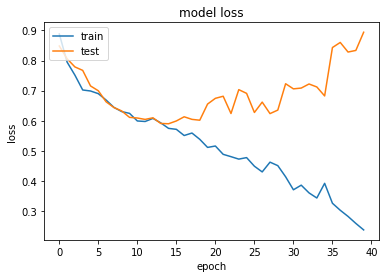

accuracy


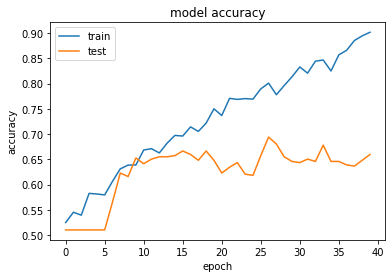

1632
              precision    recall  f1-score      support
0              0.446857  0.718750  0.551092   544.000000
1              0.797886  0.555147  0.654743  1088.000000
accuracy       0.609681  0.609681  0.609681     0.609681
macro avg      0.622372  0.636949  0.602917  1632.000000
weighted avg   0.680877  0.609681  0.620192  1632.000000
     0    1
0  391  153
1  484  604
         Class    0    1
0  DUPLICATION  229  315
1  OTHER-LINKS  255  289
2    NON-LINKS  391  153
mappedtype        pred
Composition       0        55
                  1        96
Duplication       0       229
                  1       315
General Relation  0       153
                  1       154
Non-Link          0       391
                  1       153
Temporal/Causal   0        47
                  1        39
dtype: int64
         Class    0    1
0  DUPLICATION  229  315
1  OTHER-LINKS  255  289
2    NON-LINKS  391  153
         Dataset       ACC       AUC
0  R_test_linked  0.609681  0.695885
       

In [54]:
LTOLvNL_preds = do_model('R_LTOLvNL')